# 1. Predicting Continuous Target Variables with Regression Analysis
## Basic imports

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.insert(1, '../..')
from imports.methods import plot_decision_regions

# 2. Exploring the Housing dataset
## 1. Loading the Housing dataset into a data frame

Description, which was previously available at: [https://archive.ics.uci.edu/ml/datasets/Housing](https://archive.ics.uci.edu/ml/datasets/Housing)

Attributes:
    
<pre>
1. CRIM      per capita crime rate by town
2. ZN        proportion of residential land zoned for lots over 
                 25,000 sq.ft.
3. INDUS     proportion of non-retail business acres per town
4. CHAS      Charles River dummy variable (= 1 if tract bounds 
                 river; 0 otherwise)
5. NOX       nitric oxides concentration (parts per 10 million)
6. RM        average number of rooms per dwelling
7. AGE       proportion of owner-occupied units built prior to 1940
8. DIS       weighted distances to five Boston employment centres
9. RAD       index of accessibility to radial highways
10. TAX      full-value property-tax rate per $10,000
11. PTRATIO  pupil-teacher ratio by town
12. B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks 
                 by town
13. LSTAT    % lower status of the population
14. MEDV     Median value of owner-occupied homes in $1000s
</pre>

In [5]:
df = pd.read_csv('data/housing.data.txt',
                 header=None,
                 sep='\s+')

df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 
              'NOX', 'RM', 'AGE', 'DIS', 'RAD', 
              'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


## 2. Visualizing the important characteristics of a dataset
- A scatterplot matrix allows us to visualize the pair-wise correlations between the different features in this dataset in one place

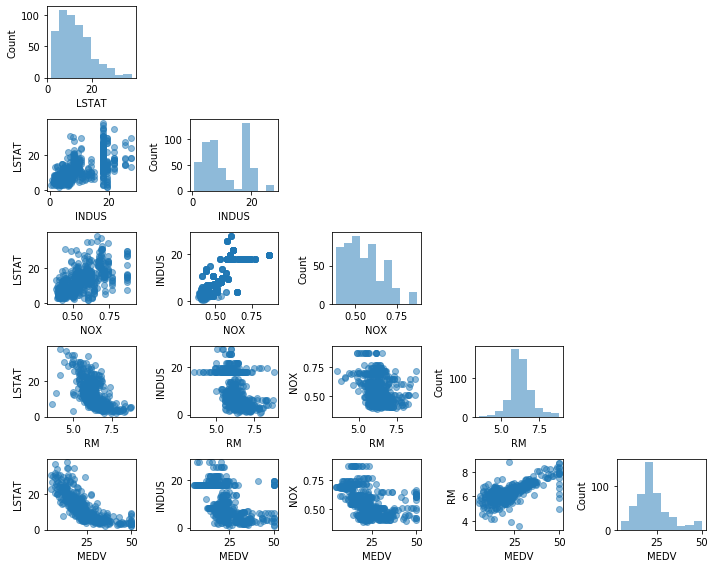

In [6]:
from mlxtend.plotting import scatterplotmatrix

cols = ['LSTAT', 'INDUS', 'NOX', 'RM', 'MEDV']

scatterplotmatrix(df[cols].values, figsize=(10, 8), 
                  names=cols, alpha=0.5)
plt.tight_layout()
plt.show()

## 3. Calculating the correlation matrix and plotting it as a heat map
- We are interested in the features that have a high correlation with our target variable, in this case MEDV
- We are also interested in matching good correlation scores with linear realtionships between the corresponding features (0.70 and clearly linear, as can be seen on the previous plot, between RM and MEDV)

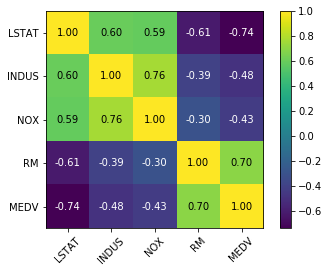

In [7]:
from mlxtend.plotting import heatmap

cm = np.corrcoef(df[cols].values.T)
hm = heatmap(cm, row_names=cols, column_names=cols)

plt.show()

# 3. Implementing an ordinary least squares linear regression model
- Linear regression can be understood as obtaining the best-fitting straight line through the examples of our training data
## 1. Solving regression for regression parameters with gradient descent
- Essentially, OLS regression can be understood as Adaline without the unit step function so that we obtain continuous target values instead of the class labels -1 and 1
### 1. Implement a simple linear regression model

In [8]:
class LinearRegressionGD(object):

    def __init__(self, eta=0.001, n_iter=20):
        self.eta = eta
        self.n_iter = n_iter

    def fit(self, X, y):
        self.w_ = np.zeros(1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        return self.net_input(X)

### 2. Get a single variable RM values to train a model that can predict MEDV

In [9]:
X = df[['RM']].values
y = df['MEDV'].values

### 3. Standardize the variables for better convergence of the GD algorithm

In [11]:
from sklearn.preprocessing import StandardScaler

sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten()

### 4. Train the regressor

In [12]:
lr = LinearRegressionGD()
lr.fit(X_std, y_std)

### 5. Plot the cost as function of the number of epochs over the training dataset
- We are doing this to check that the algorithm converged to a cost minimum (here, a global cost minimum)

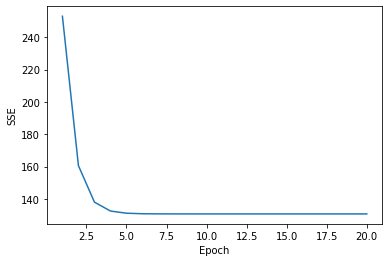

In [16]:
plt.plot(range(1, lr.n_iter+1), lr.cost_)
plt.ylabel('SSE')
plt.xlabel('Epoch')
plt.show()

### 6. Visualize how well the linear regression line fits the training data 
- As we can see, the linear regression line reflects the general trend that house prices tend to increase with the number of rooms
- Althought this makes sense, the data also tells us that the number of rooms does not explain house prices very well in many cases

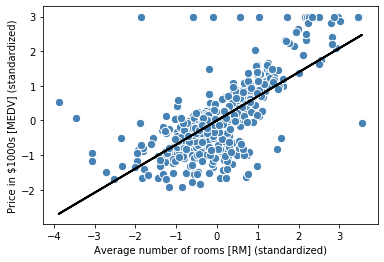

In [17]:
def lin_regplot(X, y, model):
    plt.scatter(X, y, c='steelblue', edgecolor='white', s=70)
    plt.plot(X, model.predict(X), color='black', lw=2)    
    return 

lin_regplot(X_std, y_std, lr)
plt.xlabel('Average number of rooms [RM] (standardized)')
plt.ylabel('Price in $1000s [MEDV] (standardized)')

plt.show()

### 7. Scale the predicted price back onto the original price axis

In [18]:
num_rooms_std = sc_x.transform(np.array([[5.0]]))
price_std = lr.predict(num_rooms_std)
print("Price in $1000s: %.3f" % sc_y.inverse_transform(price_std))

Price in $1000s: 10.840


### 8. Side note: we do not have to update the weights of the intercept if we are working with standardized variables

In [19]:
print('Slope: %.3f' % lr.w_[1])
print('Intercept: %.3f' % lr.w_[0])

Slope: 0.695
Intercept: -0.000


## 2. Estimating the coefficient of a regression model via scikit-learn
### 1. Train a linear regression model from scikit-learn
- The linear regression implementation in scikit-learn works better with unstandardized variables, since it does not use (S)GD-based optimization

In [20]:
from sklearn.linear_model import LinearRegression

slr = LinearRegression()
slr.fit(X, y)
y_pred = slr.predict(X)
print('Slope: %.3f' % slr.coef_[0])
print('Intercept: %.3f' % slr.intercept_)

Slope: 9.102
Intercept: -34.671


### 2. Train a linear regression model from scikit-learn
- We have different model coefficients in comparison to our GD implementation, but we can qualitatively see that it fits the data similarly well

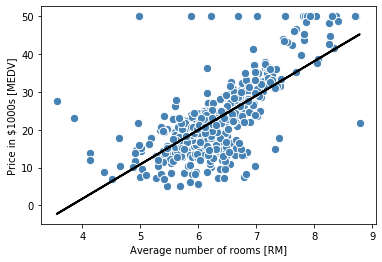

In [21]:
lin_regplot(X, y, slr)
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000s [MEDV]')

plt.show()

# 4. Fitting a robust regression model using RANSAC
- RANSAC algorithm fits a regression model to a subset of the data, inliers
## 1. Train a RANSAC model

In [24]:
from sklearn.linear_model import RANSACRegressor

ransac = RANSACRegressor(LinearRegression(), 
                         max_trials=100, 
                         min_samples=50, 
                         loss='absolute_loss', 
                         residual_threshold=5.0, 
                         random_state=0)


ransac.fit(X, y)

RANSACRegressor(base_estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                                n_jobs=None, normalize=False),
                is_data_valid=None, is_model_valid=None, loss='absolute_loss',
                max_skips=inf, max_trials=100, min_samples=50, random_state=0,
                residual_threshold=5.0, stop_n_inliers=inf,
                stop_probability=0.99, stop_score=inf)

## 2. Plot the inliers and outliers from the fitted RANSAC-linear regression model

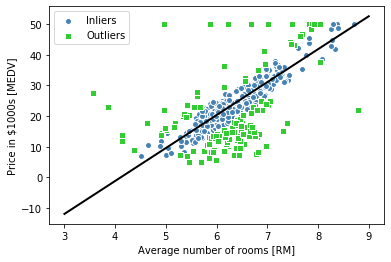

In [25]:
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
plt.scatter(X[inlier_mask], y[inlier_mask],
            c='steelblue', edgecolor='white', 
            marker='o', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask],
            c='limegreen', edgecolor='white', 
            marker='s', label='Outliers')
plt.plot(line_X, line_y_ransac, color='black', lw=2)   
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000s [MEDV]')
plt.legend(loc='upper left')

plt.show()

## 3. Compare the model coefficients to the model without RANSAC

In [26]:
print('Slope: %.3f' % ransac.estimator_.coef_[0])
print('Intercept: %.3f' % ransac.estimator_.intercept_)

Slope: 10.735
Intercept: -44.089


# 5. Evaluating the performance of linear regression models
## 1. Split the dataset

In [28]:
from sklearn.model_selection import train_test_split

X = df.iloc[:, :-1].values
y = df['MEDV'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

## 2. Train the model on the training and predict for both training and testing sets

In [29]:
slr = LinearRegression()

slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

## 3. Plot a residual plot
- Residuals are results of substracting the true target variables from our predicted responses
- If we see patterns in a residual plot, it means that our model is unable to capture some explanatory information, which has leaked into the residuals
- We can also use residual plots to detect outliers, which are represented by the points with a large deviation from the centerline

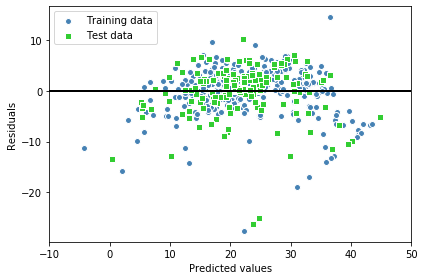

In [30]:
plt.scatter(y_train_pred,  y_train_pred - y_train,
            c='steelblue', marker='o', edgecolor='white',
            label='Training data')
plt.scatter(y_test_pred,  y_test_pred - y_test,
            c='limegreen', marker='s', edgecolor='white',
            label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, color='black', lw=2)
plt.xlim([-10, 50])
plt.tight_layout()

plt.show()

## 4. Compute the MSE and R^2
- Larger testing MSE is an indicator of overfitting
- The MSE is unbounded in contrast to the classification accuracy, its interpretation depends on the dataset and feature scaling
- R^2 can be understood as a standardized version of the MSE
- In other words, it is the fraction of response variance that is captured by the model

In [32]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE train: 19.958, test: 27.196
R^2 train: 0.765, test: 0.673


# 6. Using regularized methods for regression
## 1. Train a L1 (LASSO) penalized model
- Using a L1 model usually leads to sparse weight vectors

In [34]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
y_train_pred = lasso.predict(X_train)
y_test_pred = lasso.predict(X_test)
print(lasso.coef_)

[-0.11311792  0.04725111 -0.03992527  0.96478874 -0.          3.72289616
 -0.02143106 -1.23370405  0.20469    -0.0129439  -0.85269025  0.00795847
 -0.52392362]


## 2. Compute the MSE and R^2

In [36]:
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE train: 20.926, test: 28.876
R^2 train: 0.753, test: 0.653


## 3. Different approaches to regularization
### 1. Ridge regression

In [ ]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=1.0)

### 2. LASSO regression

In [ ]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=1.0)

### 3. Elastic Net regression
- A compromise between the L1 and L2 approaches

In [ ]:
from sklearn.linear_model import ElasticNet
elanet = ElasticNet(alpha=1.0, l1_ratio=0.5)

# 7. Turning a linear regression model into a curve - polynomial regression
## 1. Add a second-degree polynomial term

In [41]:
from sklearn.preprocessing import PolynomialFeatures

X = np.array([258.0, 270.0, 294.0, 
              320.0, 342.0, 368.0, 
              396.0, 446.0, 480.0, 586.0])\
             [:, np.newaxis]

y = np.array([236.4, 234.4, 252.8, 
              298.6, 314.2, 342.2, 
              360.8, 368.0, 391.2,
              390.8])

lr = LinearRegression()
pr = LinearRegression()
quadratic = PolynomialFeatures(degree=2)
X_quad = quadratic.fit_transform(X)

## 2. Fit a simple linear regression model for comparison

In [42]:
lr.fit(X, y)
X_fit = np.arange(250, 600, 10)[:, np.newaxis]
y_lin_fit = lr.predict(X_fit)

## 3. Fit a multiple regression model on the transformed features for polynomial regression

In [43]:
pr.fit(X_quad, y)
y_quad_fit = pr.predict(quadratic.fit_transform(X_fit))

## 4. Plot the results

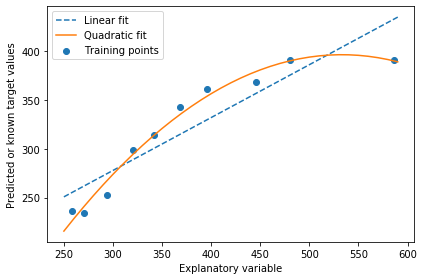

In [44]:
plt.scatter(X, y, label='Training points')
plt.plot(X_fit, y_lin_fit, label='Linear fit', linestyle='--')
plt.plot(X_fit, y_quad_fit, label='Quadratic fit')
plt.xlabel('Explanatory variable')
plt.ylabel('Predicted or known target values')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

## 5. Compute the MSE and R^2 evaluation metrics

In [45]:
y_lin_pred = lr.predict(X)
y_quad_pred = pr.predict(X_quad)

print('Training MSE linear: %.3f, quadratic: %.3f' % (
        mean_squared_error(y, y_lin_pred),
        mean_squared_error(y, y_quad_pred)))
print('Training R^2 linear: %.3f, quadratic: %.3f' % (
        r2_score(y, y_lin_pred),
        r2_score(y, y_quad_pred)))

Training MSE linear: 569.780, quadratic: 61.330
Training R^2 linear: 0.832, quadratic: 0.982
